In [2]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

  0%|          | 0/36 [00:00<?, ?it/s]

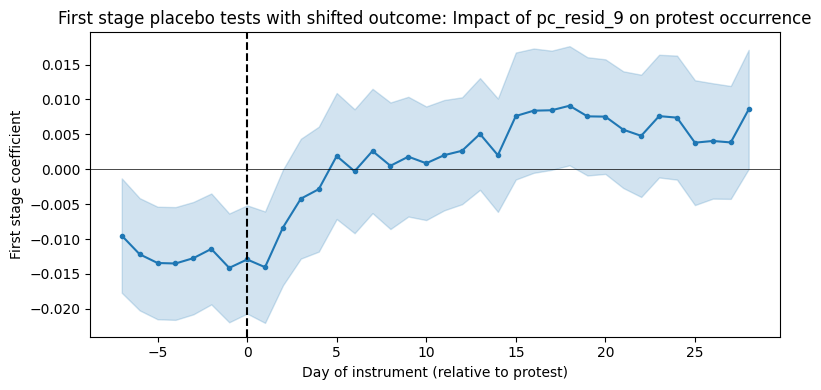

In [7]:
import matplotlib.pyplot as plt

from src.models.time_series import instrumental_variable_liml, regression
from src.visualization.impacts import plot_impact_ts

weather_vars = [
    "weather_prcp_lag0",
    "weather_tavg_lag0",
    "weather_tmax_lag0",
    "weather_tmin_lag0",
    "weather_snow_lag0",
    "weather_wspd_lag0",
    "weather_wpgt_lag0",
    "weather_pres_lag0",
    "weather_tsun_lag0",
]
covid_vars = [
    "covid_retail_and_recreation_lag0",
    "covid_grocery_and_pharmacy_lag0",
    "covid_parks_lag0",
    "covid_residential_lag0",
    "covid_transit_stations_lag0",
    "covid_workplaces_lag0",
    "covid_stringency_index_lag0",
]

<Axes: >

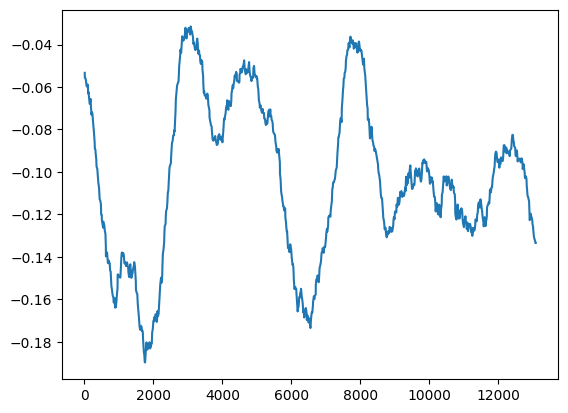

In [ ]:
from src.models.time_series import get_lagged_df

df = get_lagged_df(
    "media_combined_protest",
    instruments="pc_weather_season",
    lags=range(-7, 1),
    step=1,
    cumulative=True,
    ignore_group=True,
    ignore_medium=True,
    region_dummies=True,
)
list(df.columns)
df.query("region_Berlin_lag0 == 1")["pc_seasonal_7"].plot()

In [ ]:
from src.models.instrumental_variable import get_rf_params

rf1, rf2 = get_rf_params()
print(rf1, rf2)
print(rf1 == rf2)

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200} {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
True


In [ ]:
from src.models.instrumental_variable import check_for_improvement

results = check_for_improvement("weather_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.195 ± 0.057 -- t-test p=0.880
RandomForestClassifier: 0.219 ± 0.073 vs 0.213 ± 0.081 -- t-test p=0.761


In [ ]:
results = check_for_improvement("covid_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.196 ± 0.058 -- t-test p=0.770
RandomForestClassifier: 0.221 ± 0.073 vs 0.189 ± 0.114 -- t-test p=0.973


  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: xlabel='Shift (days)', ylabel='Coefficient'>

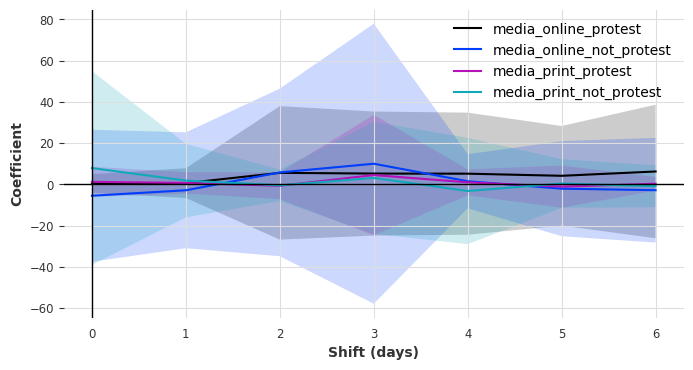

In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instruments=["weather_prcp"],
    lags=range(-7, 1),
    ignore_group=True,
    n_jobs=1,
)
results
plot_impact_ts(results, "occ_protest")

  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: xlabel='Shift (days)', ylabel='Coefficient'>

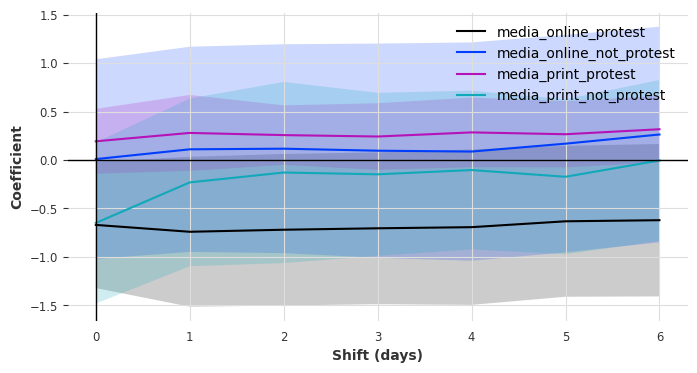

In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instrument="covid_residential",
    lags=range(-7, 1),
    ignore_group=True,
    n_jobs=1,
)
results
plot_impact_ts(results, "occ_protest")

  0%|          | 0/28 [00:00<?, ?it/s]

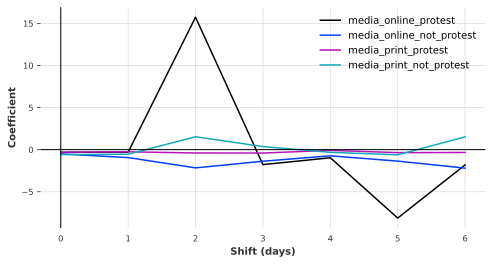

,coef,predictor,ci_lower,ci_upper,sargan,lag,step,target
0,-0.318449,occ_protest,-0.924280,0.287381,0.382231,0,0,media_online_protest
1,-0.300188,occ_protest,-1.680253,1.079877,0.065085,0,1,media_online_protest
2,15.732609,occ_protest,-13281.159234,13312.624453,0.008018,0,2,media_online_protest
3,-1.776222,occ_protest,-12.444097,8.891654,0.016109,0,3,media_online_protest
4,-0.962370,occ_protest,-3.687390,1.762651,0.049779,0,4,media_online_protest
5,-8.128474,occ_protest,-293.253751,276.996803,0.011376,0,5,media_online_protest
6,-1.808921,occ_protest,-6.403043,2.785200,0.052274,0,6,media_online_protest
7,-0.503122,occ_protest,-1.596435,0.590191,0.637404,0,0,media_online_not_protest
8,-0.943247,occ_protest,-4.413367,2.526872,0.037655,0,1,media_online_not_protest
9,-2.164674,occ_protest,-11.805192,7.475845,0.020752,0,2,media_online_not_protest


In [ ]:
from src.models.time_series import instrumental_variable_liml, plot_impact_ts

_, results = instrumental_variable_liml(
    target="protest",
    treatment="occ_protest",
    instruments=[
        "weather_prcp",
        "weather_tavg",
        "weather_tmin",
        "weather_tmax",
        "weather_snow",
        "weather_tsun",
        "weather_wspd",
        "weather_wpgt",
        "weather_pres",
    ],
    lags=range(-7, 1),
    ignore_group=True,
    binarize=True,
    n_jobs=1,
)
plot_impact_ts(results, "occ_protest", ci=False)
plt.show()
results

Sargan-Hansen test:

H0: The instruments are valid, that is they are uncorrelated with the error term of the structural equation.
See: InstrumentalVariablesEstimation2023, sheppardBashtageLinearmodelsRelease2023

In [ ]:
# season-independent params

In [ ]:
# TODO: validation
# res.wooldridge_regression
# res.wooldridge_overid
# res.sargan